# Problem Statement

The following map shows the 6 intersections at which automatic traffic monitoring devices might be installed. A station at any particular node can monitor all the road links meeting that intersection. Numbers next to nodes reflect the monthly cost (in thousands of dollars) of operating a station at that location. This problem is known as the set covering problem in combinatorial optimization.

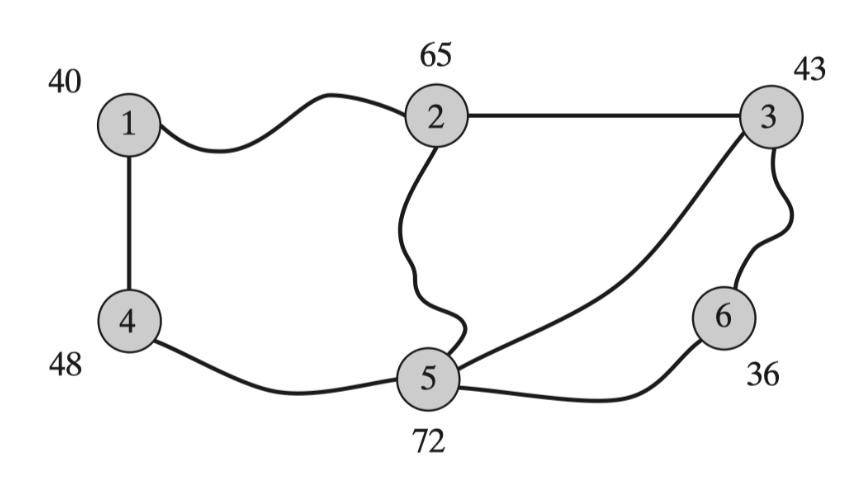


The objective is of providing full coverage at minimum total cost as a set covering integer program.

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path
from pyomo.environ import *

import pyomo.environ as pe
import pyomo.opt as po

In [2]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

#### Defining Data

In [3]:
nodes = set(range(1, 7))

In [4]:
connections = {
    (1,2):1,
    (1,4):1,
    (2,1):1,
    (2,3):1,
    (2,5):1,
    (3,2):1,
    (3,5):1,
    (3,6):1,
    (4,1):1,
    (4,5):1,
    (5,2):1,
    (5,3):1,
    (5,4):1,
    (5,6):1,
    (6,3):1,
    (6,5):1,
}

In [5]:
cost = {1:40,2:65,3:43,4:48,5:72,6:36}

## Model

Let the set of nodes be $N$, indexed as $N_i = i$ in $:i = 1,2,...,n$

If we represent the undirected graph $G = (N,E)$ with the vertex/node weight $ c:N$. Introducing a decision variable $x_n$ for selecting each node, such that $x_n = 1$ if selected, $x_n = 0$ otherwise. The ILP program formulating this minimum node cover is written as:

$$
\text{min } \sum_{n \in N} c_n x_n
$$

subject to:

$$
x_n + x_v \geq 1 \;\; \forall e = (n,v) \in E
$$

$$
x_n \in \{0,1\} \;\; \forall N
$$

The first constraint ensures that each edge is being supervised by at least one station, and the second one, by our definition, signifies the decision to choose $x_n$ or not (this can also be defined in the domain of the variable).

The edges can be defined with the help of a matrix $A$ with elements $a_{nv}$, also called the adjancency matrix:

$$
a_{nv} = \begin{cases}
      1 & \text{if node $n$ is connected to node $v$} \; (n \neq v) \\
      0 & \text{otherwise}
   \end{cases}
$$

> Note: Adjancency matrix is symmetric

Using these matrix elements, the constraint can be written as:

$$
x_n + x_v \geq a_{nv} \;\; (n, v) \in E
$$


## Implement

In [6]:
m = pe.ConcreteModel()

#### Initializing Sets

In [7]:
m.nodes = pe.Set(initialize=nodes)                       # Ignore if any warnings appear
adj = list(connections.keys())                           # Taking keys of connections and converting to list
m.A = pe.Set(within=m.nodes*m.nodes, initialize=adj)     # Adjacency Matrix for Edges

#### Initializing Parameters

In [8]:
m.connections = pe.Param(m.A,initialize=connections)
m.cost = pe.Param(m.nodes,initialize=cost)

#### Initializing Variables

In [9]:
m.X = pe.Var(m.nodes, domain=pe.Binary)

#### Defining Objective

In [10]:
obj_expr = sum(m.cost[i]* m.X[i] for i in m.nodes)
m.obj = pe.Objective(sense=pe.minimize, expr=obj_expr)

#### Defining Constraints

In [11]:
def allnodescover_rule(m,i,j):
    return (m.X[i] + m.X[j]) >= m.connections[i,j]

m.nodes_constraint =  pe.Constraint(m.A,rule=allnodescover_rule)

## Solve and Postprocess

In [13]:
solver = po.SolverFactory('glpk')
results = solver.solve(m, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpsdkknmg7.glpk.raw --wglp /tmp/tmpozurd4z1.glpk.glp --cpxlp
 /tmp/tmpnyrmm2hq.pyomo.lp
Reading problem data from '/tmp/tmpnyrmm2hq.pyomo.lp'...
/tmp/tmpnyrmm2hq.pyomo.lp:102: warning: lower bound of variable 'x2' redefined
/tmp/tmpnyrmm2hq.pyomo.lp:102: warning: upper bound of variable 'x2' redefined
16 rows, 6 columns, 32 non-zeros
6 integer variables, all of which are binary
108 lines were read
Writing problem data to '/tmp/tmpozurd4z1.glpk.glp'...
79 lines were written
GLPK Integer Optimizer 5.0
16 rows, 6 columns, 32 non-zeros
6 integer variables, all of which are binary
Preprocessing...
16 hidden packing inequaliti(es) were detected
16 rows, 6 columns, 32 non-zeros
6 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 16
Solving L

In [14]:
print("Minimum Total Cost: ",pe.value(m.obj))

Minimum Total Cost:  155.0


In [15]:
for n in m.nodes:
    if pe.value(m.X[n]) ==1:
       print("Selected Nodes are: ",n)

Selected Nodes are:  1
Selected Nodes are:  3
Selected Nodes are:  5
